# Linear Programming exercise

In [1]:
### Do the imports -- no need to change this
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
sys.path.insert(0, "src/")
from environment import GridWorldEnvironment
from MDPsolver import MDPsolver
from utils import *
from plot import *
%load_ext autoreload
%autoreload 2

***Before starting, we recall the use of the gridworld environment.***

The gridworld environment is instantiated via the class `GridWorldEnvironment`. 

***It takes 4 input values:***
- `reward_mode` : Integer between 0 and 3 for different reward profiles,
- `size`: Gridworld size,
- `prop`: Probability assigned to the event that the agent does not follow the chosen action but another one selected uniformely at random,
- `gamma`: Discount factor of the environment.

***Interface of a Gridworld instance:***
- `print(gridworld.n_states)` # return the number of states
- `print(gridworld.n_actions)` # return the number of actions
- `print(gridworld.r)` # return a matrix where each element indicates the reward corresponding to each (state, action) pair.
- `print(gridworld.gamma)` # return the discount factor
- `print(gridworld.sparseT[action])` # Input: action, Return: a matrix containing the state-to-state transition probabilities for the action passed as input.

<img src="../dynamic_programming/src/vis_gridworld.png" alt="fishy" class="bg-primary" width="400px">

In [2]:
reward_mode = 2 # see below to visualize the reward function
size = 3 # size of the gridworld (3x3)
prop = 0.1 # proportion of randomly taken steps due to noise in the environment 
gamma=0.99 # discount factor

gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
print('Reward function: \n', gridworld.r) # visualize the reward function

Reward function: 
 [[   0.    0.    0.    0.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [-100. -100. -100. -100.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]]


We will use a solver to compute the **optimal value function** to measure the suboptimality of the policies produced by our algorithms.

To access the optimal value function use `solver.v`.

In [3]:
solver = MDPsolver(gridworld) # call the MDPsolver class
solver.value_iteration() # call the value iteration method to find V^* once

## Ex 1: Solving the Primal [30 points]

We will leverage the powerful `scipy` library to solve **Linear Programs (LPs)**. Below we give an example of using the [linprog module](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html) to solve a simple LP:

\begin{aligned}
 & \min_{x := \begin{bmatrix}
x_0  \\
x_1
\end{bmatrix}  \in \mathbb{R}^2}  \begin{bmatrix}
-1  \\
4
\end{bmatrix} ^\top x
\\&  \text{s.t.}  \begin{bmatrix}
-3 & 1 \\
1 & 2 
\end{bmatrix} \mathbb{x} \le  \begin{bmatrix}
6  \\
4 
\end{bmatrix} , \quad  x_1\ge -3 \,.
\end{aligned}

The **code example below will be instructive** when you later construct the LP corresponding to the MDP.

In [4]:
from scipy.optimize import linprog # import the linear programming solver from scipy

# Note that the bounds argument in linprog is a  sequence of (min, max) pairs for each element in x, defining the minimum and maximum values.
x0_bounds = (None, None)
x1_bounds = (-3, None)

# call linear programming solver:
res = linprog([-1, 4], 
              A_ub=[[-3, 1], [1, 2]], 
              b_ub=[6, 4], 
              bounds=[x0_bounds, x1_bounds],
              method="simplex")
print('The solution is ', res.x) # access and print the solution
print(res.message) # print the message of the solver (e.g., terminated successfully)

The solution is  [10. -3.]
Optimization terminated successfully.


C:\Users\arist\AppData\Local\Temp\ipykernel_63632\2674117054.py:8: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog([-1, 4],


Now we are ready to use `linprog` to solve the LP problem in gridworld.

We define a distribution `mu` over the states.

In [5]:
mu = np.ones((gridworld.n_states,1))/gridworld.n_states # initialize mu

Next, we need to **instantiate the constraints of the primal problem**. Notice that `scipy` requires the inequality constraints in the form $A_{ub} x \leq b_{ub}$.


To this end, we rewrite the constraint $EV \geq \gamma P V + r$ in the form expected by `scipy`.

___

We can reformulate the constraint of the primal problem as:
$$
EV \geq \gamma P V + r\quad\iff\quad(\gamma P-E)V \leq -r
$$
with:
- $E\in\mathbb{R}^{|\mathcal{S}||\mathcal{A}|\times|\mathcal{S}|}$ a block matrix, with $|\mathcal{S}| \times |\mathcal{S}|$ identity matrices vertically stacked $|\mathcal{A}|$ times.
- $P\in\mathbb{R}^{|\mathcal{S}||\mathcal{A}|\times|\mathcal{S}|}$ a block matrix, with $|\mathcal{S}| \times |\mathcal{S}|$ matrices $P_a$.
- $r\in\mathbb{R}^{|\mathcal{S}||\mathcal{A}|}$, a column vector with entries $r(s,a)$.
- $V\in\mathbb{R}^{|\mathcal{S}|}$, a vector with entries $V(s)$.

In [6]:
def build_matrix(env):
    E = np.kron(np.eye(env.n_states), np.ones(env.n_actions)).T # build the matrix E
    P = env.T.transpose((1,0,2)).reshape(env.n_states*env.n_actions, -1) # build the matrix P
    return env.gamma*P - E

(Side remark: The indexing in the matrices `E` and `P` here is slightly different from the one in the lecture. This does not change any of the formulas from the slides since both matrices are indexed in the same way, consistently throughout this exercise. You may ignore this comment.)

Then, use the function `linprog` of `scipy` to solve the dual problem and show that you can retrieve the same $V^\star$ computed with the solver and stored in `solver.v`

$$
\begin{align*}
\min_V \quad& (1-\gamma)\langle\mu, V\rangle \\
\text{s.t.}\quad & (\gamma P-E)V \leq -r
\end{align*}
$$

In [7]:
# Call linear programming solver with the correct inputs:
c = (1 - gridworld.gamma)*mu
bounds = [(None, None)] * gridworld.n_states
primal_out = linprog(c, 
                     A_ub=build_matrix(gridworld), 
                     b_ub= -gridworld.r.flatten(),
                     method="simplex",
                     bounds=bounds)

C:\Users\arist\AppData\Local\Temp\ipykernel_63632\4229553706.py:4: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  primal_out = linprog(c,


(*Hint:* Check slide 23 for the matrix form (or slide 8), lecture 3 to recall the primal.)

We can access the solution of the primal LP using `primal_out.x`. Compare the error with the value of `solver.v`.

In [8]:
np.linalg.norm(primal_out.x - solver.v) # plot 2-norm

4.111484296790486e-14

The LP solver works very well we have an error of $4.11\cdot 10^{-14}$

***Question***

By running the following two cells, plot (in matrix form) `mu` and the difference between `solver.v` and `primal_out.x`. Then, answer the following question: Can we ensure that `np.linalg.norm(primal_out.x - solver.v)` is zero (up to numerical errors) for the current value of `mu`?  

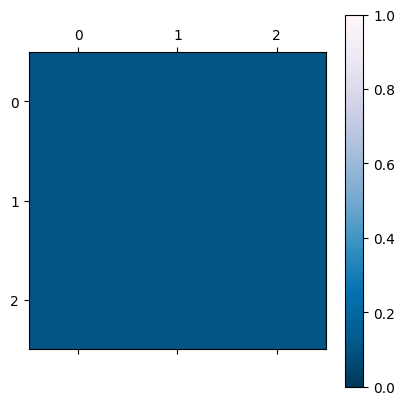

In [9]:
plt.matshow(mu.reshape(size, size), cmap='PuBu_r', vmin=0,vmax=1) # plot distribution mu over states 
plt.colorbar()

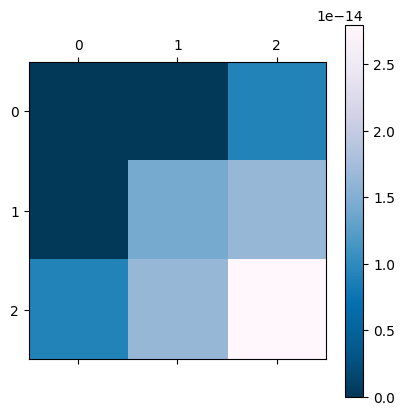

In [10]:
plt.matshow((solver.v - primal_out.x).reshape(size, size), cmap='PuBu_r') # plot the difference between the value function and the solution of the linear program
plt.colorbar()

**Answer**

We cannot guarantee that the solver's solution and the solution of the LP will be identicall (i.e. with a zero error), however we can expect it ot be very close to zero (in the above example $4.11\cdot10^{-14}$ which is practically zero).

Next, we repeat the same experiment with a different value of `mu`. 

Note that we do **not** overwrite `mu` or `primal_out` (but instead have `mu2` and `primal_out2`, since for all other exercises, we will use the original, uniform `mu`.)

In [11]:
# overwrite mu with a new distribution:
mu2 = np.zeros((gridworld.n_states,1))
mu2[-3] = 1

Fill in the following, as before but for the distribution `mu2`.

In [12]:
# solve the LP with the new mu2:
c2 = (1 - gridworld.gamma)*mu2
bounds2 = [(None, None)] * gridworld.n_states

primal_out2 = linprog(c2, 
                     A_ub=build_matrix(gridworld), 
                     b_ub= -gridworld.r.flatten(),
                     method="simplex",
                     bounds=bounds)

C:\Users\arist\AppData\Local\Temp\ipykernel_63632\1718541281.py:5: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  primal_out2 = linprog(c2,


We compare with the value computed by Value Iteration `solver.v`.

In [13]:
np.linalg.norm(primal_out2.x - solver.v) # plot 2-norm

2.772246430099758

Note that now, the optimal solution of the primal LP `primal_out2.x` and the optimal value function `solver.v` do not coincide anymore! 

This is despite the fact that the optimal value function `solver.v` was computed **right in the beginning**, before we even initialized the `mu` for solving the LP the first time. So `solver.v` is definitely the correct optimal value function for each state.

**Question:**

Why does it make sense that the two values do not coincide?

**Answer:**

$\mu(s)$ has to be strictly greater than zero, as stated by the following lemma:

**Lemma: LP formulation and $V^\star$**

$V^\star$ is the unique optimal solution to the LP formulation for any positive weights $\mu(s)$.

We can verify this by adding a small offset to the initial distribution:


In [14]:
mu2_offset = np.zeros((gridworld.n_states,1)) + 1e-5
mu2_offset[-3] = 1

c2_ = (1 - gridworld.gamma)*mu2_offset
bounds2 = [(None, None)] * gridworld.n_states
primal_out2_ = linprog(c2_, 
                     A_ub=build_matrix(gridworld), 
                     b_ub= -gridworld.r.flatten(),
                     method="simplex",
                     bounds=bounds)

np.linalg.norm(primal_out2_.x - solver.v) # plot 2-norm

C:\Users\arist\AppData\Local\Temp\ipykernel_63632\3175608843.py:6: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  primal_out2_ = linprog(c2_,


4.111484296790486e-14

***Question***

We plot again in matrix form `mu2`, `solver.v` and `primal_out2.x`. Then answer the following: What can happen in the states where `mu2 = 0`?

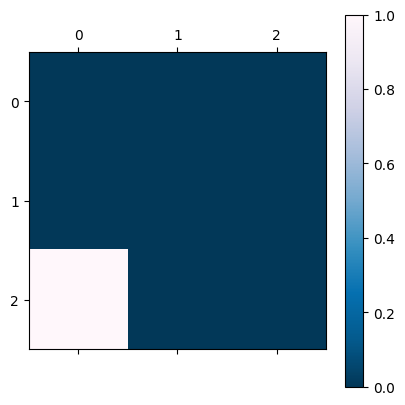

In [15]:
plt.matshow(mu2.reshape(size, size), cmap='PuBu_r', vmin=0,vmax=1) # plot distribution mu over states
plt.colorbar()

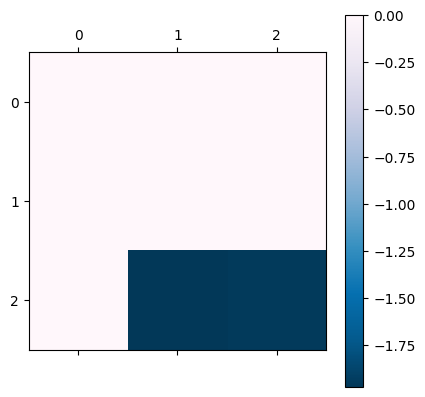

In [16]:
plt.matshow((solver.v - primal_out2.x).reshape(size, size), cmap='PuBu_r') # plot the difference between the value function and the solution of the linear program
plt.colorbar()

**Answer:**

In the states where $\mu = 0$, the LP formulation does not incentivize the algorithm to correctly value those states. This happens because the states associated with the zero values of $\mu$ do not contribute to the objective function $(1 - \gamma)\langle\mu,V\rangle$, the solver wants to minimize the objective function, which does not takes into account states with a $\mu$ value of zero

# Ex 2: Solving the Dual [30 points]

Try now to solve the dual using again the `linprog` routine of scipy. 

Note that we did **not** overwrite `mu` (i.e. it is still uniform, and `primal_out.x` is the primal solution for this `mu`).

(*Hint:* Check slide 23 for the matrix form (or slide 11), lecture 3 to recall the dual.)

$$
\begin{align*}
\max_\lambda \quad & \langle\lambda, r\rangle  \\
\text{s.t.}\quad & (\gamma P^T - E^T)\lambda = -(1-\gamma)\mu \\
& \lambda \succcurlyeq 0
\end{align*}
\quad\equiv\quad
\begin{align*}
\min_\lambda \quad & -\langle\lambda, r\rangle\\
\text{s.t.}\quad & (\gamma P^T - E^T)\lambda = -(1-\gamma)\mu \\
& \lambda \succcurlyeq 0
\end{align*}
$$

In [17]:
def build_matrix_dual(env):
    E = np.kron(np.eye(env.n_states), np.ones(env.n_actions)) # build the matrix E
    P = env.T.transpose((1,0,2)).reshape(env.n_states*env.n_actions, -1).T # build the matrix P
    return env.gamma*P - E

In [18]:
# solve the dual LP with the correct inputs:
c = gridworld.r.flatten()

bounds = [(0, None)] * gridworld.n_states * gridworld.n_actions

dual_out = linprog(-c, 
              A_eq=build_matrix(gridworld).T, 
              b_eq=-(1 - gridworld.gamma)*mu,
              method="simplex",
              bounds=bounds)

C:\Users\arist\AppData\Local\Temp\ipykernel_63632\3523188160.py:6: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  dual_out = linprog(-c,


We verify that **strong duality** holds:

In [19]:
dual_value = dual_out.x.dot(gridworld.r.reshape(gridworld.n_states*gridworld.n_actions)) # compute the optimal value of the dual
primal_value = (1 - gridworld.gamma)*primal_out.x.dot(mu)[0] # compute the optimal value of the primal
abs(primal_value - dual_value) # print the absolute difference between the primal and dual optimum

8.326672684688674e-17

Note that the solution of the dual problem gives us the **optimal occupancy measure**. Given this:

1. Obtain the **greedy policy** given the solution of the primal problem.

2. **Evaluate** this policy and **compare** the obtained values with the solution of the dual problem.

In [20]:
def evaluate_policy(pi, env, tol=1e-10):
    """Implementation of policy evaluation through iteratively applying using a certain policy 
    Args:
        pi: a policy
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    while True:
        v_old = np.copy(v)
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v)
        for s in range(env.n_states):
            action_taken = pi[s]
            v[s] = q[s,action_taken]
        if np.linalg.norm(v - v_old) < tol:
            break
    return v, q

In [21]:
pi = dual_out.x.reshape(gridworld.n_states,gridworld.n_actions).argmax(axis=1) # side remark/explanation: We know a deterministic optimal policy exists. It turns out that we can find it by checking for which component a lambda_opt(s,a) is > 0, and then setting pi_opt(a|s) = 1 for that action.
v,q = evaluate_policy(pi,gridworld) # evaluate the policy
print(np.linalg.norm(v-primal_out.x)) # print the 2-norm between the value function and the solution of the primal LP

4.111484296790486e-14


***Questions (3 points)***

Derive the dual from the primal. That is, show that it indeed the dual linear program of the primal program (and that thus the values coincide by strong duality).

(*Hint:* You may consult the supplementary material of lecture 3, slide 9 and 10 in the appendix to read about strong duality in LPs. Make sure to explain step by step why it works.)

***Answer:***

We will derive the dual problem $(DP)$ using Lagrangian duality. Let's define the lagrangian for a minimization problem without equality constraints:
$$
\begin{align*}
\min_x\quad & f(x) \\
\text{s.t.}\quad & Ax \leq b
\end{align*}
\quad\rightarrow\quad
\mathcal{L}(x, \lambda) = f(x) + \lambda^T(Ax - b)
$$

We have the following equalities:
$$
f(x) = \sup_\lambda \mathcal{L}(x,\lambda) \quad \implies \quad \inf P = \inf_x f(x) = \inf_x \sup_\lambda \mathcal{L}(x, \lambda)
$$

We can introduce the dual maximization problem as:

$$
g(\lambda) = \inf_x \mathcal{L}(x,\lambda)

\quad\rightarrow\quad

\begin{align*}
D:\quad&\max_{\lambda\succcurlyeq 0}\quad & g(x) 
\end{align*}

$$

Now let's look at the LP we are interested in and apply this concept:
$$
\begin{align*}
\min_V \quad& (1-\gamma)\langle\mu, V\rangle \\
\text{s.t.}\quad & (\gamma P-E)V \leq -r
\end{align*}
\quad\rightarrow\quad
\begin{align*}
\mathcal{L}(V, \lambda) &= (1 - \gamma)\mu^T V + \lambda^T[(\gamma P-E)V + r]\\
&= [(1 -\gamma)\mu^T + \lambda^T(\gamma P - E)]V + \lambda^T r \\
&=[(1 -\gamma)\mu + (\gamma P - E)^T\lambda]^T V + \lambda^T r
\end{align*}
$$

$\mathcal{L}$ is linear in $V$ so the infimum of this function is can be defined in the following way:

$$
g(\lambda) = 
\begin{cases}
\lambda^T r & \text{if} \quad (1 -\gamma)\mu + (\gamma P - E)^T\lambda = 0\\
-\infty & \text{otherwise}
\end{cases}
$$
The above result is obtained by the linearity of the Lagrangian if $(1 -\gamma)\mu + (\gamma P - E)^T\lambda$ is not null we will have a slope which will pull the infimum to $-\infty$ in the case that this term is zero the infimum is equal to the constant term of the function. Based on this result we define the dual problem as:
$$
\begin{align*}
\max_{\lambda}\quad & \lambda^T r\\
 \text{s.t.}\quad & (1 -\gamma)\mu + (\gamma P - E)^T\lambda = 0\\
 & \lambda\succcurlyeq 0
\end{align*}
\quad\equiv\quad
\begin{align*}
\max_{\lambda}\quad & \lambda^T r\\
 \text{s.t.}\quad & E^T\lambda = (1 -\gamma)\mu + \gamma P^T\lambda\\
 & \lambda\succcurlyeq 0
\end{align*}
$$

Strong Duality holds if $\sup D = \inf P$.

# Ex 3: Implement REPS with known dynamics [39 points]

In this exercize you will **implement the REPS algorithm** as we have seen in the lectures.
Namely, recall the following **details of the algorithm**:

1. **Initialization** (uniform): $\forall s, a, \lambda_0(s,a) = \frac{1}{|\mathcal{S}||\mathcal{A}|}$;

2. **REPS loss computation**: $\mathcal{L}(\lambda, V) = (1-\gamma) \langle \mu, V \rangle + \frac{1}{\eta}\log{\langle \lambda, \exp{(\eta(r+\gamma P V - E V))} \rangle}$;

3. **Solving for the values**: $V_{k}=\text{argmin}_{V}~{\mathcal{L}(\lambda_k, V)}$, for this we will use the `minimize` function from `scipy.optimize`;

4. **Updating the occupancy measure:** $\lambda_{k+1} \propto \lambda_k \cdot \exp{(\eta (r+\gamma P V_{k} - E V_{k}))}$ (unnormalized, you then must make sure it sums to 1 in every step).

In [22]:
from scipy.optimize import minimize
from scipy.special import logsumexp, softmax
from plot import plot_log_lines, plot_lines

In [23]:
def reps_loss(lambda_, V, eta, initial): # return the reps loss
    exp_term = eta * (gridworld.r.flatten() + build_matrix(gridworld) @ V)
    lse = logsumexp(exp_term, b=lambda_)
    loss = (1 - gamma) * initial.T @ V + 1/eta * lse
    return loss

def minimize_reps_loss(lambda_, eta, initial): # find minimizer of the reps loss
    loss = lambda V : reps_loss(lambda_, V, eta, initial)
    V = minimize(loss, np.zeros(gridworld.n_states), method = "CG", options={'maxiter': 1000})
    return V.x

In [24]:
K = 40 # number of iterations
mu = np.ones((gridworld.n_states,1))/gridworld.n_states # initialize mu again to the uniform distribution (not needed, just to be safe)

#initialize the variables
subopts = []
feasibility_errors = []
lambda_ = np.ones(gridworld.n_states*gridworld.n_actions)/gridworld.n_states/gridworld.n_actions
iterates = [lambda_]
subopts.append(-lambda_.T.dot(gridworld.r.reshape(gridworld.n_states*gridworld.n_actions))+(1-gridworld.gamma)*mu.T.dot(solver.v)[0])
feasibility_error = np.linalg.norm(build_matrix(gridworld).T.dot(lambda_) + (1-gridworld.gamma)*mu)
feasibility_errors.append(feasibility_error)

# REPS: iterate over K steps
for k in range(K):
    eta = 1/np.sqrt(k+1) # set the step size
    
    V = minimize_reps_loss(lambda_, eta, mu) # minimize the reps loss
    delta = gridworld.r.reshape(gridworld.n_states*gridworld.n_actions) + build_matrix(gridworld).dot(V) # compute the advantage function
    
    new_lambda_ = lambda_ * np.exp(eta * (gridworld.r.flatten() + build_matrix(gridworld) @ V)) # update the lambda
    new_lambda_ /= np.sum(new_lambda_) # normalize the lambda_
    lambda_ = new_lambda_
    
    # store the suboptimality and feasibility errors:
    subopt = -lambda_.T.dot(gridworld.r.reshape(gridworld.n_states*gridworld.n_actions))+(1-gridworld.gamma)*mu.T.dot(solver.v)[0]
    feasibility_error = np.linalg.norm(build_matrix(gridworld).T.dot(lambda_) + (1-gridworld.gamma)*mu)
    subopts.append(subopt)
    feasibility_errors.append(feasibility_error)
    iterates.append(lambda_)

**Plot of the suboptimality of iterates produced by REPS**

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


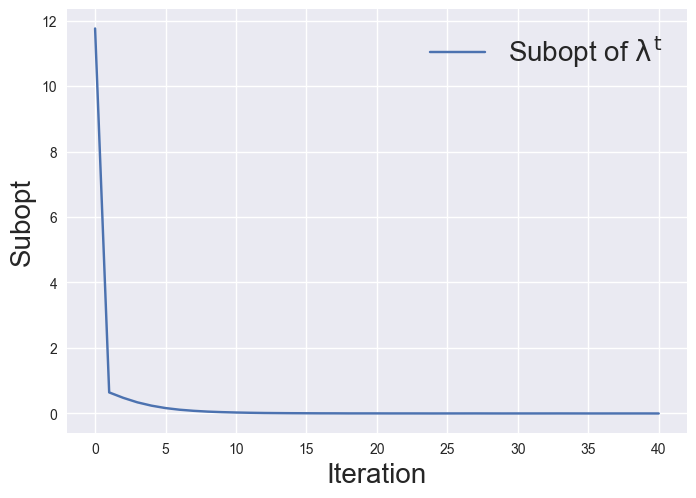

In [25]:
plot_lines([np.array(subopts)], [r"Subopt of $\lambda^t$"], ["Iteration", "Subopt"], "figs", "subopts.pdf", show=True)

**Theoretical Derivation of REPS**

Prove that the iterates of REPS are equivalent to the iterates produced by the following updates:

$$ \lambda_{k+1} = \mathrm{argmax}_{\lambda} \left( \langle \lambda, r \rangle - \frac{1}{\eta} \left\langle \lambda,~ \log\left(\frac{\lambda}{\lambda_k}\right) \right\rangle \right) \quad \text{s.t.} \quad E^T \lambda = \gamma P^T \lambda + (1 - \gamma) \mu. $$

(*Hint:* Check the slides of lecture if you do not know where to start.)

**Answer:**

We want to show the equivalence between the following two optimization problems:

$$
P: \quad
\lambda_{k+1}^V = \mathrm{argmax}_{\lambda}  \langle \lambda, r \rangle  + \gamma P^T \lambda - E^T \lambda + (1 - \gamma) \mu - \frac{1}{\eta} \left\langle \lambda,~ \log\left(\frac{\lambda}{\lambda_k}\right) \right\rangle.
$$

and

$$
P': \quad
\lambda_{k+1} = \mathrm{argmax}_{\lambda} \left( \langle \lambda, r \rangle - \frac{1}{\eta} \left\langle \lambda,~ \log\left(\frac{\lambda}{\lambda_k}\right) \right\rangle \right) \quad \text{s.t.} \quad E^T \lambda = \gamma P^T \lambda + (1 - \gamma) \mu.
$$

Starting from $P'$ we can obtain $P$ through Lagrangian duality. We can start by calculatring the Lagrangian of $P'$:
$$
\mathcal{L}(\lambda,~V) = \langle \lambda, r \rangle - \frac{1}{\eta} D_{KL}(\lambda, \lambda_k) + \langle V, \gamma P^T \lambda - E^T \lambda + (1 - \gamma) \mu \rangle
$$

Note that in this case we have an equality constraint not an inequality constraint therefore we don't need to add an additional constraint imposing $V \succcurlyeq 0$

Now by definition of the dual problem we have the following series of equalities:

$$\sup P = \sup_\lambda \underbrace{\inf_V \mathcal{L}(\lambda,~V)}_{f(\lambda)} \overset{convex~in~V}{\overset{concave~in~\lambda}{=}} = \inf_V \underbrace{\sup_\lambda \mathcal{L}(\lambda,~V)}_{g(V)} = \inf D
$$

Looking only at the first equality we can identify the expression that we want i.e.:

$$
\lambda_{k+1} = \arg \max_\lambda \quad \min_V \quad \langle \lambda, r \rangle - \frac{1}{\eta} D_{KL}(\lambda, \lambda_k) + \langle V, \gamma P^T \lambda - E^T \lambda + (1 - \gamma) \mu \rangle
$$

and if we follow the notation of the class (slide 37), we can re-formulate the expression in the following way:

$$
\lambda_{k+1}^V = \mathrm{argmax}_{\lambda}  \langle \lambda, r \rangle  + \gamma P^T \lambda - E^T \lambda + (1 - \gamma) \mu - \frac{1}{\eta} \underbrace{\left\langle \lambda,~ \log\left(\frac{\lambda}{\lambda_k}\right) \right\rangle}_{D_{KL}(\lambda, \lambda_k)}.
$$

**Plot the constraints violation**

Plot the value of $||(E^T - \gamma P^T)\lambda - (1 - \gamma) \mu || $, varying the parameter `maxiter` of the `scipy.minimize` function.

(To be clear: in the code above, modify this line ```minimize(loss, np.zeros(gridworld.n_states), method = "CG", options={'maxiter': 1000})``` and plot for varying `maxiter`.)

In [26]:
def minimize_reps_loss(lambda_, eta, initial, maxiter):  # find minimizer of the reps loss with varying maxiter
    loss = lambda V: reps_loss(lambda_, V, eta, initial)
    V = minimize(loss, np.zeros(gridworld.n_states), method="CG", options={'maxiter': maxiter})
    return V.x


maxiter_values = [10, 50, 100, 500, 1000]

feasibility_errors_ = {m: [] for m in maxiter_values}

# maxiter_values = np.arange(40)

# Run REPS with varying maxiter values
for maxiter in maxiter_values:
    # Initialize lambda for each maxiter test
    lambda_ = np.ones(gridworld.n_states*gridworld.n_actions)/(gridworld.n_states*gridworld.n_actions)

    for k in range(K):
        eta = 1/np.sqrt(k+1)
        V = minimize_reps_loss(lambda_, eta, mu, maxiter)
        delta = gridworld.r.reshape(gridworld.n_states*gridworld.n_actions) + build_matrix(gridworld).dot(V)  # compute the advantage function

        new_lambda_ = lambda_ * np.exp(eta * delta)  # update the lambda
        new_lambda_ /= np.sum(new_lambda_)  # normalize the lambda_
        lambda_ = new_lambda_       
        
        feasibility_error = np.linalg.norm(build_matrix(gridworld).T @ lambda_ + (1 - gridworld.gamma) * mu)
        feasibility_errors_[maxiter].append(feasibility_error)

# Convert feasibility_errors to a format  for plot_lines function
errors_to_plot = [np.array(feasibility_errors_[m]) for m in maxiter_values]
labels = [f"maxiter={m}" for m in maxiter_values]


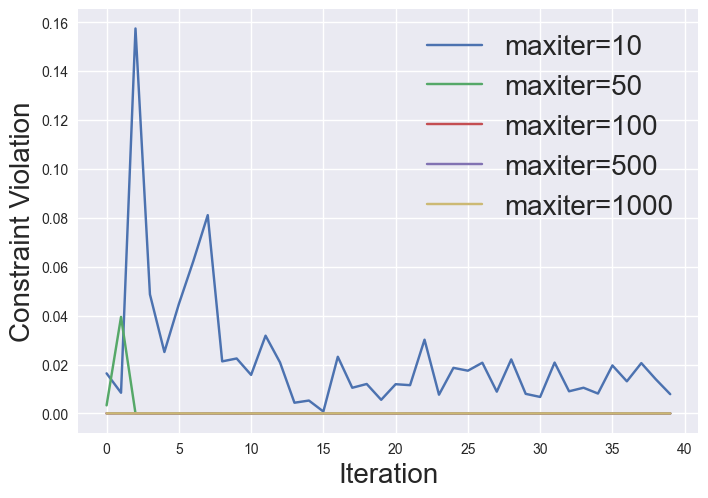

In [27]:
# Plot the constraint violations for different maxiter values
plot_lines(errors_to_plot, labels, ["Iteration", "Constraint Violation"], "figs", "constraint_violations", show=True)

In [28]:

# # Plot the constraint violations for different maxiter values
# plot_log_lines(errors_to_plot, labels, ["Maxiter Value", "Log Constraint Violation"], "figs", "constraint_violations", show=True)

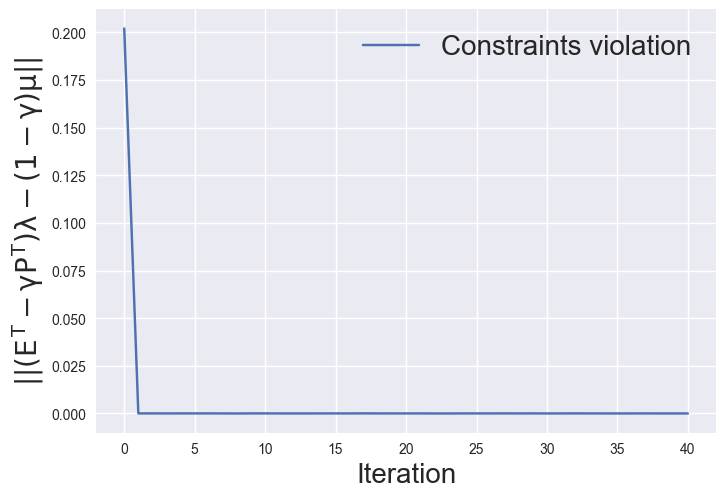

In [29]:
plot_lines([np.array(feasibility_errors)], [r"Constraints violation"], ["Iteration", "$|| (E^T - \gamma P^T)\lambda - (1 - \gamma) \mu ||$"], "figs", "constraints.pdf", show = True)

**Question**

Empirically, is the value of $||(E^T - \gamma P^T)\lambda - (1 - \gamma) \mu || $ higher for high or low values of `maxiter`?

Explain why this is the case.

**Answer:**

Empirically, the constraint violations are higher for lower values of `maxiter` and tends to decrease as `maxiter` increases, which can be clearlt seen in the logarithmic plot.

This trend can be explained by the iterarive nature of the `minimize` function, when `maxiter` is low the optimizer cannot reach the optimal value and obtain an accurate value of $V_k$, resulting in less accurate solutions. Now when `maxiter` is high, the optimizer manages to achieve an approximation close to the optimal values, allowing for good $V_k$ and therefore $\lambda$ s that satisfy the contraint of the maximization problem.

**Question:**

Strictly speaking, are the actual iterates $\lambda_k$ in the implementation above valid occupancy measures? In other words, is $E^T \lambda_k = \gamma P^T \lambda_k + (1 - \gamma) \mu$ strictly satisfied for all iterates? Explain why this is (not) the case.

**Answer:**

The actual iterates $\lambda_k$ are not guaranteed to be valid occupancy measures for all iterates because the equality constraint is not strictly enforced for each iteration.
This is happening because the constraint is enforced only in the loss function during the optimization and not on $\lambda$ s updates.

So without a mechanism that makes sure that $\lambda_k$ satisfy the constraint at each step, the equality will generally not hold.

**Plot of the suboptimality of the policies extracted from the $\lambda^k$'s**

*Extract the policies from the $\lambda^k$-iterates:* $$\pi_{\lambda^k}(a |s) = \frac{\lambda_k(s,a)} {\sum_{a\in\mathcal{A}}\lambda_k(s,a)}.$$

In [30]:
def extract_policies_from_occ_measures(occ_measures): # extract the policies from the occupancy measures
    policies = []
    for occ_measure in occ_measures:
        policy = np.zeros((gridworld.n_states, gridworld.n_actions)) # initialize the policy
        occ_measure = occ_measure.reshape(gridworld.n_states, -1) # reshape the occupancy measure
        states_occ_measure = occ_measure.sum(axis=1) # compute the occupancy measure over states (not state-action pairs)
        for s in range(gridworld.n_states):
            policy[s] = occ_measure[s]/sum(occ_measure[s]) # compute the policy
        policies.append(policy)
        
    return policies

In [31]:
policies = extract_policies_from_occ_measures(iterates)

*Extract the occupancy measures from the policies:* $$ \lambda_{\pi_{\lambda^k}}(s,a) = (1 - \gamma)\sum^{\infty}_{t=0} \gamma^t \mathbb{P}[s_t=s,a_t=a | s_0 \sim \mu, \pi_{\lambda^k}].$$

In [32]:
def extract_occ_measures_from_policies(policies): # extract the occupancy measures from the policies (we do not require you to follow this)
    occ_measures = []
    for policy in policies:
        v = - (1 - gridworld.gamma)*(mu.repeat(gridworld.n_actions,axis=1)*policy).reshape(gridworld.n_states*gridworld.n_actions)
        matrix = np.eye(gridworld.n_states*gridworld.n_actions)
        T_pi = np.expand_dims(gridworld.T.transpose((1,0,2)),axis=3).repeat(gridworld.n_actions, axis=3)
        pi_tensor = np.expand_dims(policy, axis=(0,1)).repeat(T_pi.shape[0], axis=0).repeat(T_pi.shape[1], axis=1)
        T_pi = T_pi*pi_tensor
        matrix = gridworld.gamma*T_pi.reshape(gridworld.n_states*gridworld.n_actions,gridworld.n_states*gridworld.n_actions)- matrix
        occ_measure = np.linalg.solve(matrix.T, v)
        occ_measures.append(occ_measure)
    return occ_measures

In [33]:
occ_measures = extract_occ_measures_from_policies(policies)

*Check whether $\lambda_{\pi_{\lambda_k}} = \lambda_k$*:

In [34]:
# compute the difference between the occupancy measures and the iterates
diff_occ_measures = [np.linalg.norm(occ_measure - iterate) for occ_measure, iterate in zip(occ_measures, iterates)] 

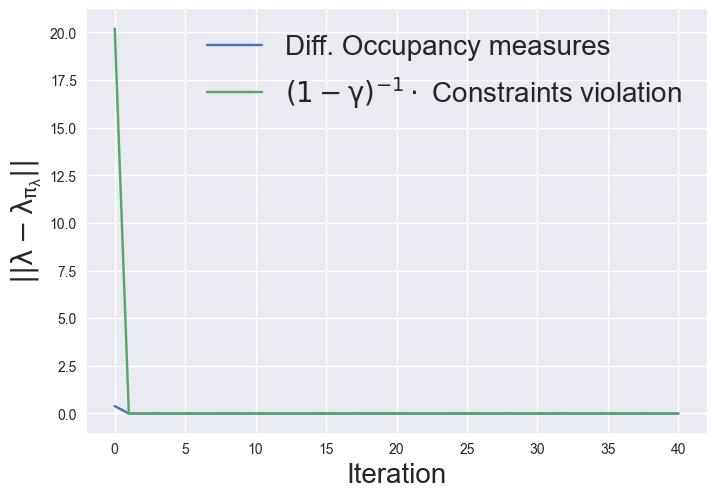

In [35]:
# plot the difference between the occupancy measures and the iterates
plot_lines([np.array(diff_occ_measures), np.array(feasibility_errors)/(1 - gridworld.gamma)], [r"Diff. Occupancy measures", r"$(1-\gamma)^{-1}\cdot$ Constraints violation"], ["Iteration", "$|| \lambda - \lambda_{\pi_\lambda}||$"], "figs", "diff_occ_measures.pdf", show = True)

**Questions**

- How does the norm of the difference $|| \lambda^k - \lambda_{\pi_{\lambda^k}}||$ relate to the constraint violation $|| (E^T - \gamma P^T)\lambda^k - (1 - \gamma) \mu ||$ ?

- If $|| (E^T - \gamma P^T)\lambda^k - (1 - \gamma) \mu ||$ is small, can you conclude that $|| \lambda^k - \lambda_{\pi_{\lambda^k}}||$ is also small ? 

*Hint: For both, you can answer leveraging the result in Lemma 3 of https://arxiv.org/pdf/2112.14004.pdf*

- As a consequence how is $|| \lambda^k - \lambda_{\pi_{\lambda^k}}||$ affected by the value of `maxiter`?

*Hint:* Recall your empirical finding about the impact of `maxiter` (above).

***Answer:***

According to the lemma of the paper, the norm difference $|| \lambda^k - \lambda_{\pi_{\lambda^k}}||$ is related to the constraint violation $|| (E^T - \gamma P^T)\lambda^k - (1 - \gamma) \mu ||$ such that if the constraint violation is small, we can expect the difference in the occupancy measures to also be small. This is because a small violation of the constraints indicates that $\lambda^k$ is close to a correct occupancy measure. So as `maxiter` increases and the constraint violation decreases (as observed empirically), $|| \lambda^k - \lambda_{\pi_{\lambda^k}}||$ is also likely to decrease.

**Evaluate the extracted policies**

In this section, we compute the value functions of the extracted policies which is $V^{\pi_{\lambda^k}}$

In [36]:
def evaluate_policy_sequence(policies, env, tol=1e-10):
    values = []
    for pi in policies:
        v = np.zeros(env.n_states) # initialize value function
        q = np.zeros((env.n_states, env.n_actions)) #initialize Q-value
        while True:
            v_old = np.copy(v) # save a copy of value function for the convergence criterion at the step
            for a in range(env.n_actions):
                q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v) #calculate Q-value
            for s in range(env.n_states):
                v[s] = pi[s].dot(q[s]) #calculate value function by $v(s) = max_a Q(s,a)$
            if np.linalg.norm(v - v_old) < tol: # convergence criterion
                break
        values.append(v)
    return values

In [37]:
def check_correctness(policies):
    values = evaluate_policy_sequence(policies, gridworld) # evaluate the policies
    for policy,v in zip(policies,values):
        state_occ_measure = solver.mu_policy(policy, stochastic=True) # compute the state occupancy measure
        occ_measure = np.expand_dims(state_occ_measure, axis=1).repeat(gridworld.n_actions, axis=1)*policy
        primal = occ_measure.reshape(gridworld.n_states*gridworld.n_actions).dot(gridworld.r.reshape(gridworld.n_states*gridworld.n_actions)) # compute the primal value
        dual = (1 - gridworld.gamma)*mu.T.dot(v) # compute the dual value
        assert primal - dual < 1e-7
    return [ (1 - gridworld.gamma)*mu.T.dot(v) for v in values] # return the values

**Question**

Do you expect $(1 - \gamma)\langle \mu, V^{\pi_{\lambda^k}} \rangle$ to be (approximately) equal to or (very) different from $\langle \lambda^k, r \rangle $? Does the answer depend on the value of `maxiter`?

*Hint: Recall that $(1 - \gamma)\langle \mu, V^{\pi_{\lambda^k}} \rangle = \langle \lambda_{\pi_{\lambda^k}}, r \rangle $ and argue using your previous answer concerning the term $|| \lambda^k - \lambda_{\pi_{\lambda^k}}||$.*

**Answer:**

We expect $(1 - \gamma)\langle \mu, V^{\pi_{\lambda^k}} \rangle$ to be approximately equal to $\langle \lambda^k, r \rangle $, if the norm of the $|| \lambda^k - \lambda_{\pi_{\lambda^k}}||$ is small. This is due to strong duality, the optimal value of the dual problem coincides with the primal's.
$$
\text{Duality~Gap:}\quad \Delta = \inf P - \sup D
$$

where if $\Delta = 0$ we have string duality.

Now concerning `maxiter`, a higher `maxiter` results in a smaller $|| \lambda^k - \lambda_{\pi_{\lambda^k}}||$ and therefore smaller constraint violations. So a higher `maxiter` yields a $\langle \lambda^k, r \rangle $ that is closer to $(1 - \gamma)\langle \mu, V^{\pi_{\lambda^k}} \rangle$.

In [38]:
policy_values = check_correctness(policies) # check that $(1 - \gamma)\langle \mu, V^{\pi} \rangle = \langle \lambda_{\pi}, r \rangle $ for all policies.
policy_subopts = (1 - gridworld.gamma)*mu.T.dot(solver.v) - policy_values # compute the suboptimality of the policies

**Plot the suboptimalities**

Plot $(1 - \gamma)\langle \mu, V^{\pi^\star}\rangle - (1 - \gamma)\langle \mu, V^{\pi_{\lambda^k}} \rangle$.

Plot $(1 - \gamma)\langle \mu, V^{\pi^\star}\rangle - \langle \lambda^k, r \rangle$.

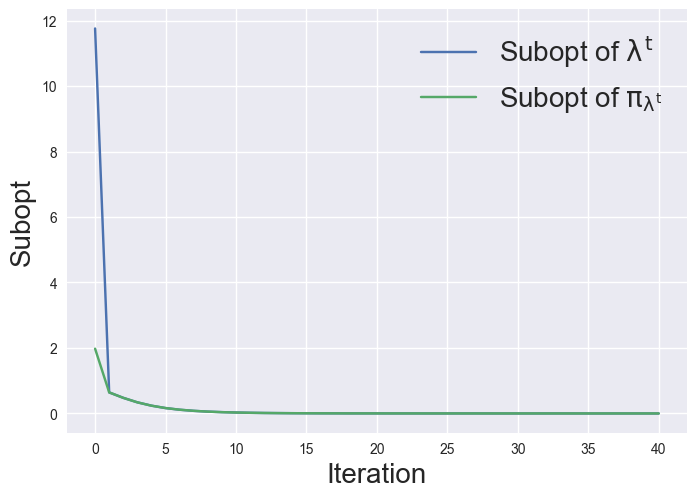

In [39]:
plot_lines([np.array(subopts), policy_subopts.flatten()], [r"Subopt of $\lambda^t$", r"Subopt of $\pi_{\lambda^t}$"], ["Iteration", "Subopt"], "figs", "subopts.pdf", show = True)

## Ex 4: Lagrangian methods [ 1 point, basically just an OPTIONAL exercise ...]

In this section we compute an optimal policy finding a saddle point of the Lagrangian $\mathcal{L}(\lambda, V)$, defined as follows

$$
\mathcal{L}(\lambda, V) = \langle \lambda, r \rangle + \langle (1 - \gamma) \mu + \gamma P^T \lambda - E^T \lambda, V \rangle .
$$

Finding a saddle point of the Lagrangian means solving the following problem:

$$ 
\mathrm{argmax}_{\lambda \geq 0} \min_{V \in \mathbb{R}^{|\mathcal{S}|}} \mathcal{L}(\lambda, V).
$$

By slide 6 in Lecture 3 it should be clear that there exists a saddle point pair $\lambda^\star, V^\star$ such that $|| V^\star ||_{\infty} \leq \frac{\max_{s,a} |r(s,a)|}{1 - \gamma}$. Therefore, we can consider looking for a saddle point over a restricted domain $\mathcal{V} = \{ V : ||V||_{\infty} \leq \frac{\max_{s,a} |r(s,a)|}{1 - \gamma} \}$:

$$ 
\mathrm{argmax}_{\lambda \geq 0} \min_{V \in \mathcal{V}} \mathcal{L}(\lambda, V).
$$

At this point we solve this problem with gradient descent ascent updates 

$$
\lambda^{k+1} \propto \lambda^k \odot \exp(\eta_{\lambda} \nabla_{\lambda} \mathcal{L}(\lambda^k, V^k)),
$$

$$
V^{k+1} = \Pi_{\mathcal{V}}[V^k - \eta_V \nabla_{V} \mathcal{L}(\lambda^k, V^k)].
$$

**Question**: 

Compute the following gradients:

$$  \nabla_{\lambda} \mathcal{L}(\lambda^k, V^k) = ??? $$

$$ \nabla_{V} \mathcal{L}(\lambda^k, V^k) = ??? $$

**Question:**

Which of the following conditions ensure that the policy $$\pi_{\lambda^k}(a |s) = \frac{\lambda_k(s,a)} {\sum_{a\in\mathcal{A}}\lambda^k(s,a)}$$ is $\epsilon$-suboptimal ?

(a) $$\langle \lambda^\star, r \rangle - \langle \lambda^k, r \rangle \leq \epsilon.$$
(b) $$(1 - \gamma)\langle \mu, V^\star \rangle - \langle \mu, V^k \rangle \leq \epsilon.$$
(c) $$ \mathcal{L}(\lambda^\star, V^k) - \mathcal{L}(\lambda^k, V^{\pi^{\lambda^k}}) \leq \epsilon.$$

Answer (a),(b) or (c) and explain.

**Answer**